### 本代码已经完成收敛
在确保神经网络设计正确、收敛性能够保证、经验池管理工具正确等后，

本代码之前最大的问题在于target与q之间的替换频率。替换频率过高导致了估计值偏差，引起算法loss指数级变大。

其它测试包括更换更好用的reward函数，收敛性能和寻优能力会得到大幅提高。300回合内即可最优。

如果在CartPole中使用了原始的reward，还是需要在done后改变一个-1最好，但是即使这样，仍然需要大量的寻优时间，不仅要让步长加长，在使用贪婪策略上也要降低贪婪的更新影响。

以上。

# 导入函数库

In [ ]:
import gym
import torch
import numpy as np
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import warnings
torch.set_default_dtype(torch.float64)
device = torch.device('cpu')

# 神经网络工具

In [ ]:
class tool_network():
  def __init__(self, env):
    # import pdb; pdb.set_trace()
    self.input_dimension = env.observation_space.shape[0]
    self.output_dimension = env.action_space.n
    self.hidden_dimension = 100
    self.model = self.network_create()

    self.learning_rate = 0.001

    self.loss_function = torch.nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def network_create(self):
    return torch.nn.Sequential(torch.nn.Linear(self.input_dimension, self.hidden_dimension),
                               torch.nn.ReLU(),
                               torch.nn.Linear(self.hidden_dimension, self.output_dimension),
                              )
    
  @staticmethod
  def network_replace(from_network, to_network):
    # import pdb;pdb.set_trace()
    # for from_param,to_param in zip(from_network.model.parameters(), 
    #                                 to_network.model.parameters()):
    #   to_param[:] = from_param
    to_network.model.load_state_dict(from_network.model.state_dict())

In [ ]:
# env = gym.make('CartPole-v0')
# state_array = []
# for i in range(32):
#   state = env.reset();state_array.append(state.tolist())
# state = torch.from_numpy(np.array(state_array))
# model_test1 = tool_network(env);model_test2 = tool_network(env)
# print(model_test1.model(state));print(model_test2.model(state))
# print(model_test1.model(state) - model_test2.model(state))
# tool_network.network_replace(model_test1,model_test2)
# print(model_test1.model(state));print(model_test2.model(state))

# for _ in range(1000):
#   optimizer = model_test1.optimizer
#   value1 = model_test1.model(state);value2 = model_test2.model(state);
#   value2 = torch.from_numpy(np.array(value2.tolist()))
#   loss = model_test1.loss_function(value1,value2)
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()
# print(model_test1.model(state) - model_test2.model(state))

# 经验池管理工具

In [ ]:
class memory():
  def __init__(self, env, length_size=20000, sample_size = 32):
    self.length_size = length_size
    self.sample_size = sample_size
    self.state_length = env.observation_space.shape[0]
    try :
      self.action_length = env.action_space.shape[0]
    except :
      self.action_length = 1
    self.column_size = self.state_length * 2 + self.action_length + 1

    self.memory_data = np.zeros((self.length_size, self.column_size))
    
    self.index = 0
    self.length_index = 0

    pass

  def store(self, state, action, reward, next_state):
    # import pdb; pdb.set_trace()
    if self.length_index < self.length_size: 
      self.length_index += 1 
    # else:
    #   return
    transition = np.hstack((state, action, reward, next_state))
    self.index = self.index % self.length_size
    self.memory_data[self.index,:] = transition

    self.index += 1
  
  def sample(self):
    # import pdb; pdb.set_trace()
    index_choice = np.random.choice(self.length_index, self.sample_size)
    data_sample =  self.memory_data[index_choice,:]
    state =  data_sample[:,0:self.state_length]
    action = data_sample[:,self.state_length:self.state_length+self.action_length ]
    reward = data_sample[:,self.state_length+self.action_length:
                         self.state_length+self.action_length+1]
    next_state = data_sample[:,self.state_length+self.action_length+1:
                             self.state_length*2+self.action_length+1]
    return state, action, reward, next_state

# DQN算法

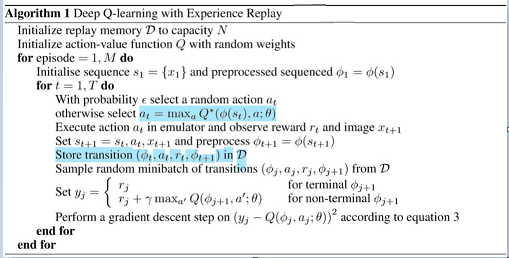

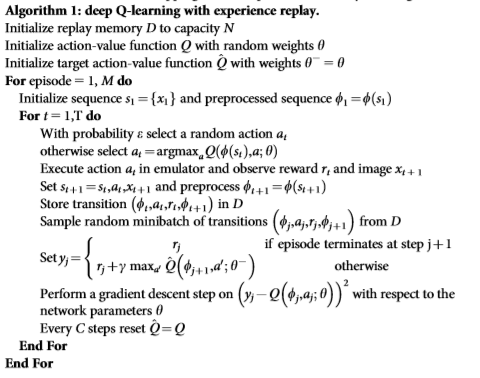

In [ ]:
! rm -rf *

In [ ]:
class agent_dqn():
  def __init__(self, env, policy_greedy=True):
    self.env = env
    self.memory = memory(env)
    self.q_network = tool_network(env)
    self.q_network_target = tool_network(env)
    tool_network.network_replace(self.q_network, self.q_network_target)

    board_record = SummaryWriter('./agent_q')
    state = torch.rand((32,self.env.observation_space.shape[0]))
    board_record.add_graph(self.q_network.model, 
                           state)
    board_record.add_graph(self.q_network_target.model, 
                           state)
    self.epsilon_max = 0.9
    self.epsilon = 0.01 if policy_greedy is True else self.epsilon_max
    self.epsilon_increment = 0.0001
    self.gamma = 0.99

    self.learning_count = 0
    self.learning_replace = 10
    pass

  def output_action(self, state, use_target=False, isgreedy=True):
    random = np.random.random()
    if use_target == True:
      network = self.q_network_target
    else:
      network = self.q_network

    if isgreedy == True:
      if self.epsilon < random:
        return_item = self.env.action_space.sample()
      else:
        return_item = network.model(state)
        return_item = np.array(return_item.tolist()).argmax()
    else:
      return_item = network.model(state)
    return return_item

  def learn(self):
    # import pdb; pdb.set_trace()
    # if self.learning_count % 600 == 0:
    #   tool_network.network_replace(self.q_network, self.q_network_target)

    state, action ,reward, next_state = self.memory.sample()

    action = np.squeeze(action).astype(np.int32)
    reward = np.squeeze(reward)
    q_value_target = self.output_action(torch.from_numpy(next_state),
                                 use_target=True, isgreedy=False)
    q_value = self.output_action(torch.from_numpy(state), 
                                 use_target=False, isgreedy=False)

    y_target = np.array(q_value.tolist())
    y_target_idx = np.arange(self.memory.sample_size, dtype=np.int32)
    # import pdb; pdb.set_trace()
    y_target[y_target_idx, action] = reward + \
              self.gamma * np.max(q_value_target.tolist(), axis=1)
    # y_target = reward + \
    #           self.gamma * np.max(q_value_target.tolist(), axis=1)

    self.loss = self.q_network.loss_function(q_value,
                                             torch.from_numpy(y_target))
    self.q_network.optimizer.zero_grad()
    self.loss.backward()
    self.q_network.optimizer.step()

    self.learning_count += 1
    if self.epsilon < self.epsilon_max :
      self.epsilon *= (1+self.epsilon_increment)


# 对应评估类

In [ ]:
class evaluate_learning():
  def __init__(self):
    self.episode = 10000
    self.env_name = 'CartPole-v0'
    self.env = gym.make(self.env_name)
    self.env = self.env.unwrapped
    self.agent_q = agent_dqn(self.env)
    pass

  def reward_normalize(self, next_state):
    x, x_dot, theta, theta_dot = next_state
    r1 = (self.env.x_threshold - abs(x))/self.env.x_threshold - 0.8
    r2 = (self.env.theta_threshold_radians - abs(theta))/self.env.theta_threshold_radians - 0.5
    reward = r1 + r2
    return reward

  def start_execute(self):
    # import pdb; pdb.set_trace()
    self.reward_array = []
    episode_count = 0
    episode_step_count = 0
    for i in range(self.episode):
      state = self.env.reset()
      episode_reward = 0
      step_count = 0
      while True:
        action = self.agent_q.output_action(torch.from_numpy(state),
                                            use_target=False, isgreedy=True)
        next_state, reward, done, info = self.env.step(action)
        # reward = self.reward_normalize(next_state)
        if done :
          reward = -1

        self.agent_q.memory.store(state, action, reward, next_state)
        state = next_state

        episode_reward += reward

        if episode_step_count > 10:
          self.agent_q.learn()

        step_count += 1
        episode_step_count += 1
        # if step_count > 5000:
        #   done =True
        if done:
          self.reward_array.append(episode_reward)
          break

      episode_count += 1
      print('episode %s, total reward is %s, loss is %s, length is %s, epsilon is %s'%
        (episode_count, episode_reward, self.agent_q.loss.item(),step_count,self.agent_q.epsilon))
      if episode_count % self.agent_q.learning_replace == (self.agent_q.learning_replace-1):
        tool_network.network_replace(self.agent_q.q_network, self.agent_q.q_network_target)



# 创建执行和评估

In [ ]:
debug_demo = evaluate_learning()
debug_demo.start_execute()

Streaming output truncated to the last 5000 lines.
episode 464, total reward is 16.0, loss is 0.06802551604417059, length is 18, epsilon is 0.028563583905686155
episode 465, total reward is 24.0, loss is 0.05491495517709394, length is 26, epsilon is 0.028637942129796663
episode 466, total reward is 44.0, loss is 0.026406982744690118, length is 46, epsilon is 0.02876997350148643
episode 467, total reward is 32.0, loss is 0.11815807665288558, length is 34, epsilon is 0.028867952983235853
episode 468, total reward is 23.0, loss is 0.04777466938347334, length is 25, epsilon is 0.028940209535985698
episode 469, total reward is 23.0, loss is 0.05807358934116464, length is 25, epsilon is 0.02901264694705337
episode 470, total reward is 8.0, loss is 0.20618683028671053, length is 10, epsilon is 0.02904167265317368
episode 471, total reward is 13.0, loss is 0.03345974112761441, length is 15, epsilon is 0.029085265669127655
episode 472, total reward is 21.0, loss is 0.08584696875502065, length i

KeyboardInterrupt: ignored

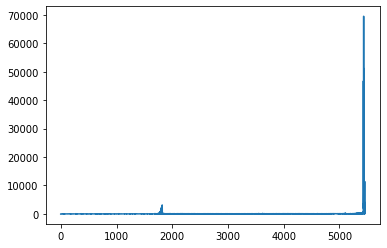

In [ ]:
import matplotlib.pyplot as plt
plt.plot(debug_demo.reward_array)

In [ ]:
%debug

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./agent_q/

# 测试效果

# 其它工具

In [ ]:
test_data_frame = pd.DataFrame(columns=['test1', 'test2'])
test_data_frame = test_data_frame.append({'test1':np.array([1,2]),'test2':np.array([3,4])}, ignore_index=True)
test_data_frame = test_data_frame.append({'test1':np.array([1,2]),'test2':np.array([3,4])}, ignore_index=True)

In [ ]:
gress_array = []
for each in test_data_frame.test1.to_list():
  gress_array.append(each.tolist())

torch.from_numpy(np.array(gress_array))


In [ ]:
test_target = np.array([[1,2],[1,2]])
test_target

In [ ]:
test_target = np.array([1,2])
test_target 

In [ ]:
test_target.shape

In [ ]:
test_target[np.newaxis,:]